# Derived from https://tensorflow.keras.io/examples/imdb_cnn/

In [48]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [49]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.9.2
Version 2, minor 9


In [50]:


from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model
import IPython
import numpy as np

# Parameters:
- max_features: number of words in the vocabulary (and hence, the length of the One Hot Encoding feature vector)
- maxlen: number of words in a review
- embedding_dims: length of word vector
- filters: number of convolutional kernels.  These are "features" created by convolution.

In [51]:
# set parameters:
max_features = 20000
maxlen = 200
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 8

special = { "<PAD>": 0, 
           "<START>": 1,
           "<UNK>": 2
           }

In [52]:
print('Loading data...')
# start_char == 1: start of sequence character is encoded with integer 1
# oov_char   == 2: Out of Vocabulary word is encoded with integer 2
# index_from == 3: The first word (i.e, most frequent) in the vocabulary is encoded with integer 3
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features,
                                                      start_char=special["<START>"],
                                                      oov_char=special["<UNK>"],
                                                      index_from=3
                                                      )
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 200)
x_test shape: (25000, 200)


# Examine the text data

In [53]:

# See https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
# word_index: maps words to rank in vocabulary (0 is most frequent)
word_index = imdb.get_word_index()

# Create word to index map
# load_data has assigned indexes 0, 1, 2 to (<PAD>, <START>, <UNK>) so load_data assigns the rank 0 word to index 3
word_index = { w:(k+3) for w,k in word_index.items() }

# Add the special characters to the word to index map
for word, idx in special.items():
  word_index[word] = idx

# Reverse map: index to word
# Index_word: map index to word
index_word = { idx:w for (w, idx) in word_index.items() }

sentiment = { 0: "negative", 1: "positive"}

# Print row header
print("i\tSentiment\treview")
print("-\t---------\t------")

# Examine the first few training examples
# An example is a sequence (of length exactly maxline (because we have added padding)
# - Sequence of integers
# - Where integer i represents word index_word[i]
for i, rev in enumerate(x_train[0:5]):
  # Map each index in the example back to word
  rev_words = [ index_word[idx] for idx in rev if idx != 0]

  # Sentiment sent is the target value
  sent = y_train[i]
  print("{i:d}:\t({sent:s})\t{r:s}".format(i=i, sent=sentiment[y_train[i]], r= " ".join(rev_words)) )

i	Sentiment	review
-	---------	------
0:	(positive)	and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lo

In [54]:
x_train.shape

(25000, 200)

In [55]:
# tf.keras.utils.to_categorical(x_train[:1000], num_classes = max_features).shape

# Utility functions

In [56]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

def plot_training(history):
  """
  Plot training and validation statistics
  - accuracy vs epoch number
  - loss     vs epoch number
  
  From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  """  
  
  # Accuracy
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  
  # Loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [57]:


def createModel(doConv=True, learn_embeddings=True):
  """
  Create a Sequential model

  Parameters
  -----------
  doConv: Boolean.  If True, create features using Convolutional Layer
  learn_embeddings: Boolean.  If True, learn embeddings; else just use OHE as embedding

  Returns
  --------
  model: Sequential model

  - First layer is an Embedding Layer
  -  if learn_embedding is True: the model will "learn" the best embedding
  -  if learn_embedding is False: the embedding will just be the OHE
  """
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  if learn_embeddings:
    # Word embeddings are trainable and small size (embedding_dims) vectors
    # Embedding layer maps 
    # - elements of sequence (OHE vectors of length max_features)
    # - to a vector of length embedding_dims
    # - where maxlen is the maximum length of a sequence
    model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  else:
    # "Embeddings" are simply One Hot Encoding of the vocabulary
    # - word embeddings are NOT trainable and LARGE size (length of vocabulary) vectors
    # NOTE: this is NOT the best way to perform OHE ! Super slow !
    #   We do this just to show that OHE is a simple type of embedding
    weights_OHE= createOHE()
    embedding_dims_OHE = weights_OHE.shape[-1]

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                      embedding_dims_OHE,
                      input_length=maxlen,
                      weights=[weights_OHE],
                      trainable=False
                     )
         )
    
  model.add(Dropout(0.2))

  if doConv:
    # we add a Convolution1D, which will learn features from "kernel_size" consecutive tokens
    model.add(Conv1D(filters,
                    kernel_size,
                    padding='valid',
                    activation='relu',
                    strides=1))
    
  # we use Global Max Pooling to eliminate the time dimensions
  # - Turns variable length sequence to fixed length
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer to create new features from the fixed length encoding
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))

  # Add Binary Classifier as final layer
  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def trainModel(model):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc']
                )
  
  es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
                ] 

  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            callbacks=callbacks)
  
  return history

def createOHE():
  mat = np.diag( np.ones(max_features))
  return mat



# Simple model
- OHE
- GlobalMaxPooling1D to convert from variable length to fixed length

Summary
- Input: Sequence (length maxlen) of words represented as integer
- Converted to sequence (length maxlen)of OHE vectors (each of length max_features)
- Pooled over sequence length dimension to give fixed length vector (length max_features)
- FC layer + Binary Classifier

Notes
- The number of parameters in the "embedding layer" (really OHE)
- Is mapping of Vocab size (max_features=5000) tokens to OHE vector of length Vocab size(max_features=5000(
  - BIG !



In [58]:
model_ohe = createModel(learn_embeddings=False, doConv=False)
model_ohe.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 20000)        400000000 
                                                                 
 dropout_15 (Dropout)        (None, 200, 20000)        0         
                                                                 
 global_max_pooling1d_4 (Glo  (None, 20000)            0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 250)               5000250   
                                                                 
 dropout_16 (Dropout)        (None, 250)               0         
                                                                 
 activation_6 (Activation)   (None, 250)               0         
                                                      

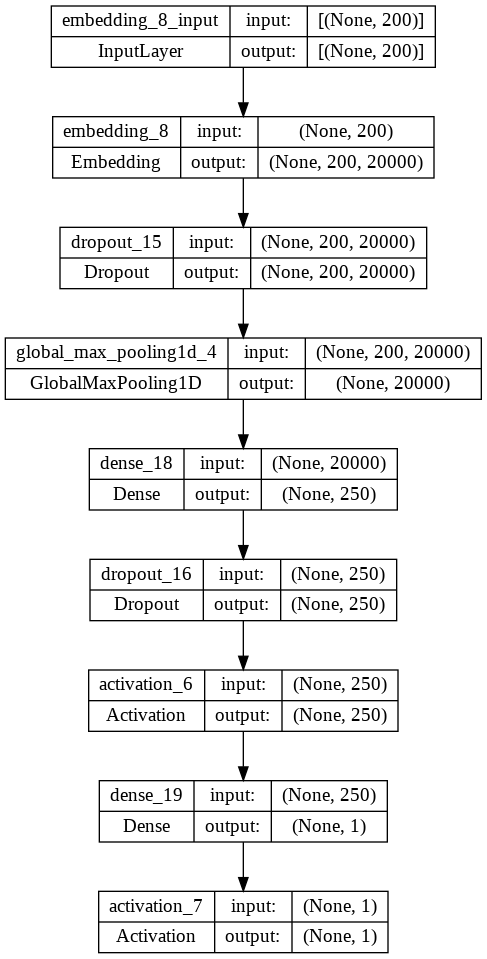

In [59]:
plotFile = plotModel(model_ohe, "imbdb_OHE_noconv")
IPython.display.Image(plotFile) 

In [60]:
history_ohe = trainModel(model_ohe)

Epoch 1/8
782/782 [==============================] - 36s 45ms/step - loss: 0.3521 - acc: 0.8451 - val_loss: 0.3063 - val_acc: 0.8697
Epoch 2/8
782/782 [==============================] - 29s 37ms/step - loss: 0.2026 - acc: 0.9187 - val_loss: 0.3334 - val_acc: 0.8602
Epoch 3/8
782/782 [==============================] - 34s 43ms/step - loss: 0.1328 - acc: 0.9468 - val_loss: 0.3576 - val_acc: 0.8633


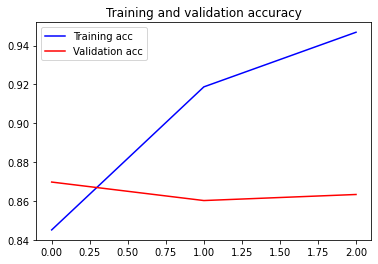

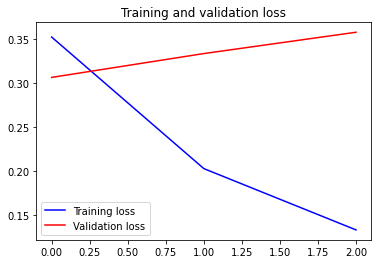

In [61]:
plot_training(history_ohe)

## Note: the test data set was used as the validation_data in the fit method above
- so nothing really to see here


In [62]:
score, acc = model_ohe.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 7s 9ms/step - loss: 0.3063 - acc: 0.8697
Test score: 0.30627116560935974
Test accuracy: 0.8697199821472168


In [63]:
print("OHE Embeddings (first few):")
embeddings_ohe = model_ohe.layers[0].get_weights()[0]
embeddings_ohe[:4,:7]

OHE Embeddings (first few):


array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

# Model with learned embeddings
- learn low-dimensional word embeddings

Summary
- same as "simple" model, but use word vectors rather than OHE

Notes
- The number of parameters in the embedding layer (learned embedding)
- Is mapping of Vocab size (max_features=5000) tokens to  vector of length embedding_dims=50 (versus Vocab size(max_features=5000 for OHE)
  - Smaller by factor of 100 !
- The Dense layer that follows also has fewer parameters
  - Factor of 100 (plus biases) because inputs are smaller by a factor of 100





In [64]:
model_emb = createModel(doConv=False)
model_emb.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 200, 50)           1000000   
                                                                 
 dropout_17 (Dropout)        (None, 200, 50)           0         
                                                                 
 global_max_pooling1d_5 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 250)               12750     
                                                                 
 dropout_18 (Dropout)        (None, 250)               0         
                                                                 
 activation_8 (Activation)   (None, 250)               0         
                                                      

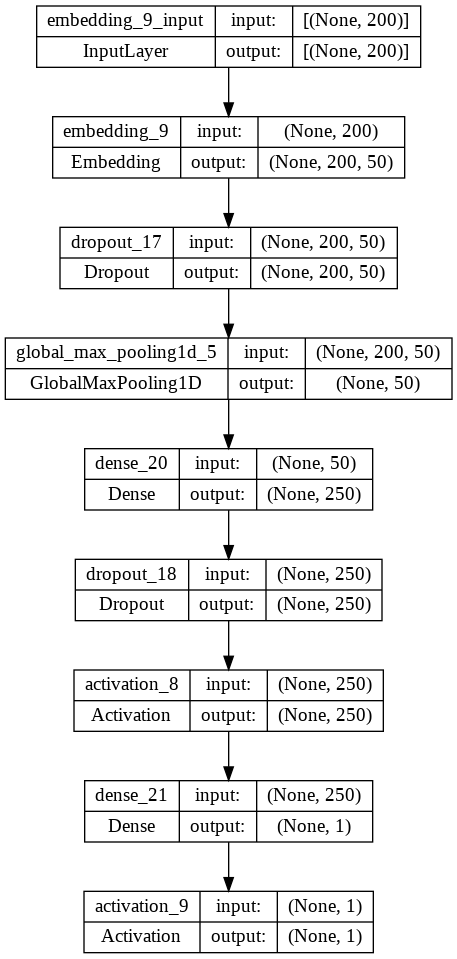

In [65]:
plotFile = plotModel(model_emb, "imbdb_emb")
IPython.display.Image(plotFile) 

In [66]:
history_emb=trainModel(model_emb)

Epoch 1/8
782/782 [==============================] - 5s 6ms/step - loss: 0.4512 - acc: 0.7774 - val_loss: 0.3309 - val_acc: 0.8565
Epoch 2/8
782/782 [==============================] - 6s 7ms/step - loss: 0.2798 - acc: 0.8846 - val_loss: 0.3121 - val_acc: 0.8654
Epoch 3/8
782/782 [==============================] - 6s 7ms/step - loss: 0.2113 - acc: 0.9164 - val_loss: 0.3181 - val_acc: 0.8613
Epoch 4/8
782/782 [==============================] - 6s 7ms/step - loss: 0.1611 - acc: 0.9372 - val_loss: 0.3625 - val_acc: 0.8466


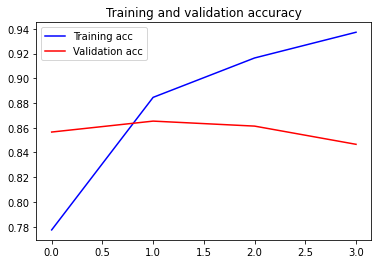

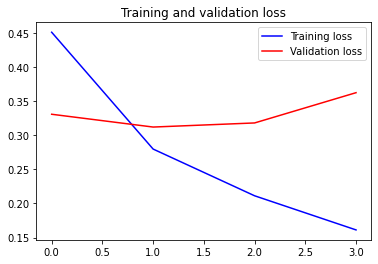

In [67]:
plot_training(history_emb)

In [68]:
score, acc = model_emb.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 2s 2ms/step - loss: 0.3121 - acc: 0.8654
Test score: 0.3120887577533722
Test accuracy: 0.8653600215911865


# Model with learned embeddings, n-grams (phrases)
- conv1d to learn n-grams

Summary
- After converting words to word vectors: use multiple kernels to find 3-grams 


In [69]:
model_emb_ngram = createModel(doConv=True)
model_emb_ngram.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 50)           1000000   
                                                                 
 dropout_19 (Dropout)        (None, 200, 50)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 250)          37750     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_22 (Dense)            (None, 250)               62750     
                                                                 
 dropout_20 (Dropout)        (None, 250)               0         
                                                     

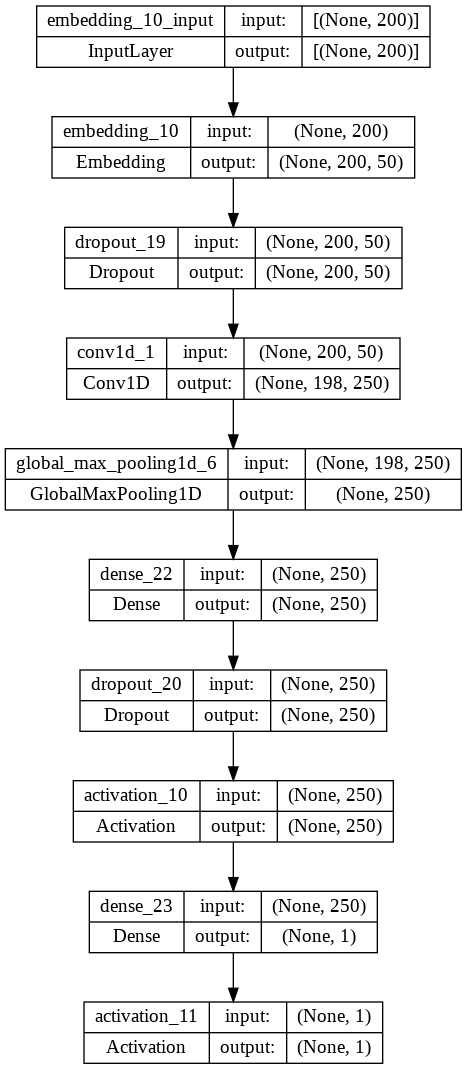

In [70]:
plotFile = plotModel(model_emb_ngram, "imbdb_emb_ngram")
IPython.display.Image(plotFile) 

In [71]:
history_emb_ngram=trainModel(model_emb_ngram)

Epoch 1/8
782/782 [==============================] - 7s 8ms/step - loss: 0.4202 - acc: 0.7901 - val_loss: 0.2967 - val_acc: 0.8741
Epoch 2/8
782/782 [==============================] - 6s 8ms/step - loss: 0.2186 - acc: 0.9150 - val_loss: 0.3145 - val_acc: 0.8657
Epoch 3/8
782/782 [==============================] - 6s 8ms/step - loss: 0.1160 - acc: 0.9582 - val_loss: 0.3056 - val_acc: 0.8857


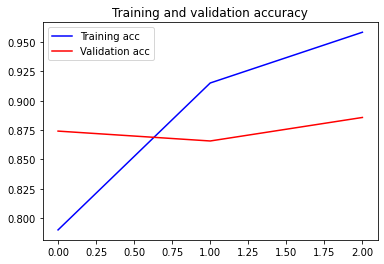

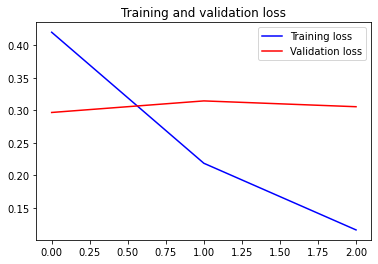

In [72]:
plot_training(history_emb_ngram)

In [73]:
score, acc = model_emb_ngram.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 2s 3ms/step - loss: 0.2967 - acc: 0.8741
Test score: 0.29671457409858704
Test accuracy: 0.8741199970245361


# Try an LSTM as a means of obtaining a finite length representation of the sequence

In [74]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential(
    [
    Embedding(max_features,
              embedding_dims,
              input_length=maxlen),
    LSTM(64, return_sequences=False),
    Dense(hidden_dims, activation='relu'),
    Dropout(0.2),
    # Classification
    Dense(1, activation='sigmoid')
  ] 
)


In [75]:
model_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 50)           1000000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dense_24 (Dense)            (None, 250)               16250     
                                                                 
 dropout_21 (Dropout)        (None, 250)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 251       
                                                                 
Total params: 1,045,941
Trainable params: 1,045,941
Non-trainable params: 0
_________________________________________________________________


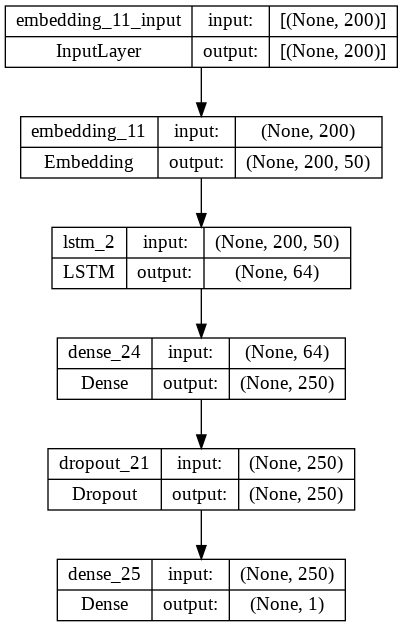

In [76]:
plotFile = plotModel(model_lstm, "imbdb_lstm")
IPython.display.Image(plotFile) 

In [77]:
history_lstm=trainModel(model_lstm)

Epoch 1/8
782/782 [==============================] - 14s 16ms/step - loss: 0.3790 - acc: 0.8256 - val_loss: 0.3070 - val_acc: 0.8710
Epoch 2/8
782/782 [==============================] - 13s 17ms/step - loss: 0.1997 - acc: 0.9248 - val_loss: 0.3210 - val_acc: 0.8682
Epoch 3/8
782/782 [==============================] - 11s 14ms/step - loss: 0.1211 - acc: 0.9558 - val_loss: 0.5261 - val_acc: 0.8304


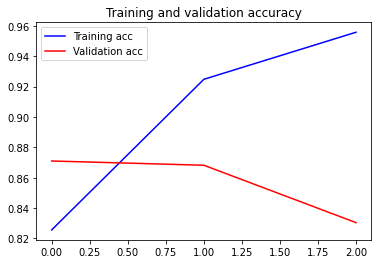

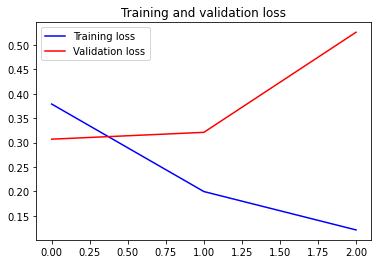

In [78]:
plot_training(history_lstm)

## LSTM w/o One Hot Encoding the input: what happens ?
- Trying this b/c attempting to OHE the data runs out of memory


In [79]:
model_lstm_nohe = Sequential(
    [
    LSTM(64, return_sequences=False, input_shape=(maxlen,1)),
    Dense(hidden_dims, activation='relu'),
    Dropout(0.2),
    # Classification
    Dense(1, activation='sigmoid')
  ] 
)



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_26 (Dense)            (None, 250)               16250     
                                                                 
 dropout_22 (Dropout)        (None, 250)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 251       
                                                                 
Total params: 33,397
Trainable params: 33,397
Non-trainable params: 0
_________________________________________________________________


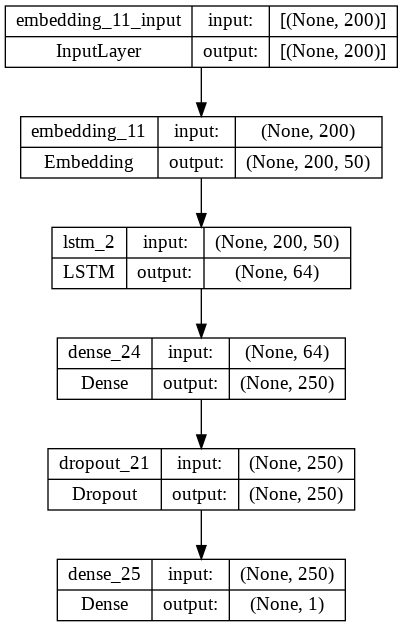

In [80]:
model_lstm_nohe.summary()

plotFile = plotModel(model_lstm, "imbdb_lstm_nohe")
IPython.display.Image(plotFile) 

In [81]:
history_lstm_nohe=trainModel(model_lstm_nohe)

Epoch 1/8
782/782 [==============================] - 14s 16ms/step - loss: 0.6947 - acc: 0.5107 - val_loss: 0.6914 - val_acc: 0.5234
Epoch 2/8
782/782 [==============================] - 10s 13ms/step - loss: 0.6888 - acc: 0.5360 - val_loss: 0.6841 - val_acc: 0.5589
Epoch 3/8
782/782 [==============================] - 10s 13ms/step - loss: 0.6861 - acc: 0.5474 - val_loss: 0.6823 - val_acc: 0.5608
Epoch 4/8
782/782 [==============================] - 10s 13ms/step - loss: 0.6846 - acc: 0.5521 - val_loss: 0.6821 - val_acc: 0.5620


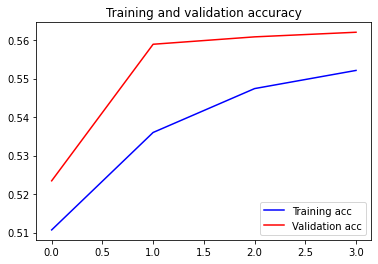

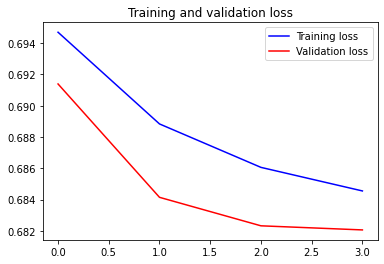

In [82]:
plot_training(history_lstm_nohe)

# Try a Transformer

Based on https://keras.io/examples/nlp/text_classification_with_transformer/

In [83]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



In [84]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [85]:
vocab_size = max_features
embed_dim = embedding_dims

num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

model_transf = Sequential( [
                            TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim),
        TransformerBlock(embed_dim, num_heads, ff_dim),
        # Reduce sequence to finite length representation
        GlobalMaxPooling1D(),
        Dense(hidden_dims, activation='relu'),
        Dropout(0.2),
        # Classification
      Dense(1, activation='sigmoid')
])

## Can't show model summary or plot until it is "built" (after training)
- Probably because of the custom layers using Functional model

In [86]:
history_transf=trainModel(model_transf)

Epoch 1/8
782/782 [==============================] - 11s 12ms/step - loss: 0.4425 - acc: 0.7724 - val_loss: 0.3094 - val_acc: 0.8678
Epoch 2/8
782/782 [==============================] - 12s 15ms/step - loss: 0.1982 - acc: 0.9256 - val_loss: 0.3522 - val_acc: 0.8568
Epoch 3/8
782/782 [==============================] - 9s 12ms/step - loss: 0.1087 - acc: 0.9616 - val_loss: 0.3949 - val_acc: 0.8586


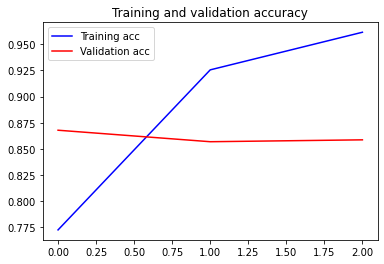

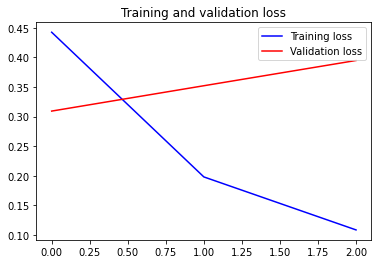

In [87]:
plot_training(history_transf)

In [88]:
model_transf.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  (None, 200, 50)          1010000   
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_2 (Transf  (None, 200, 50)          23832     
 ormerBlock)                                                     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_30 (Dense)            (None, 250)               12750     
                                                                 
 dropout_25 (Dropout)        (None, 250)             

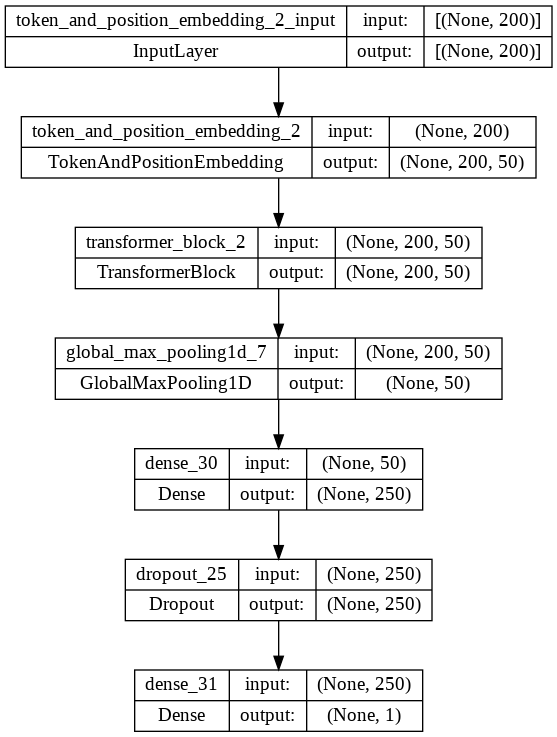

In [89]:
plotFile = plotModel(model_transf, "imbdb_transf")
IPython.display.Image(plotFile) 

# Try the Functional model from the Keras site
- Versus our own Sequential
- Same results, slightly different number of parameters ?

In [90]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
# outputs = layers.Dense(2, activation="softmax")(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_transf_o = tf.keras.Model(inputs=inputs, outputs=outputs)

In [91]:
model_transf_o.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 50)          1010000   
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_3 (Transf  (None, 200, 50)          23832     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_28 (Dropout)        (None, 50)                0   

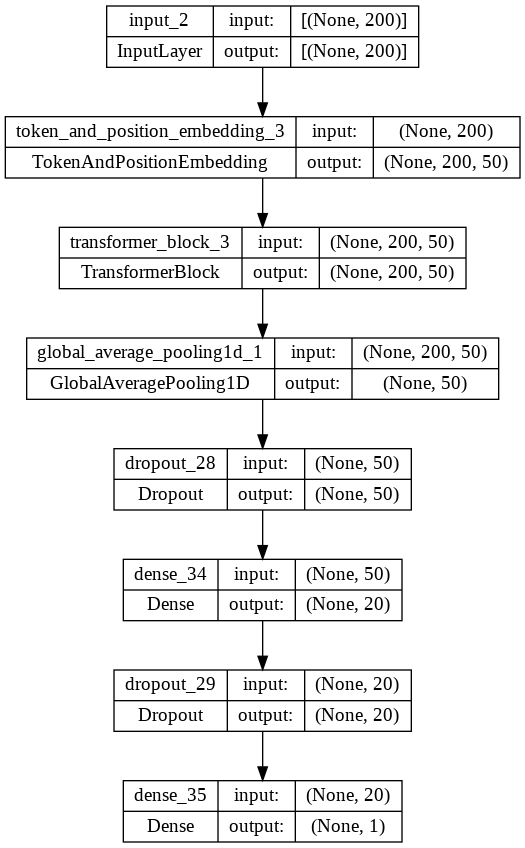

In [92]:
plotFile = plotModel(model_transf_o, "imbdb_transf_o")
IPython.display.Image(plotFile) 

In [93]:
history_transf_o=trainModel(model_transf_o)

Epoch 1/8
782/782 [==============================] - 11s 12ms/step - loss: 0.3804 - acc: 0.8186 - val_loss: 0.2995 - val_acc: 0.8728
Epoch 2/8
782/782 [==============================] - 9s 12ms/step - loss: 0.1933 - acc: 0.9272 - val_loss: 0.3171 - val_acc: 0.8721
Epoch 3/8
782/782 [==============================] - 9s 12ms/step - loss: 0.1252 - acc: 0.9586 - val_loss: 0.4410 - val_acc: 0.8497


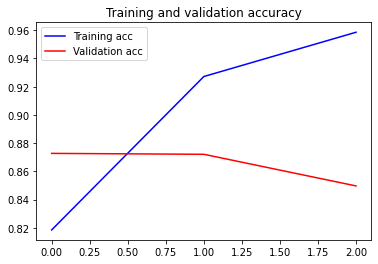

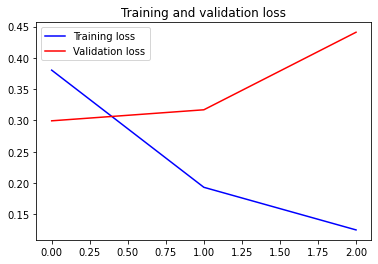

In [94]:
plot_training(history_transf_o)